# Set-up

In [2]:
# Change this to where you would like to save all your results
import os
os.chdir("/cellar/users/aklie/projects/ML4GLand/issues/41")  # TODO: change this to your own directory
cwd = os.getcwd()
cwd

'/cellar/users/aklie/projects/ML4GLand/issues/41'

In [3]:
# Configure EUGENe directories, if you do not set these, EUGENe will use the default directories
from eugene import settings
settings.logging_dir = "./tutorial_logs" # Directory where EUGENe will save Tensorboard training logs and model checkpoints to
settings.output_dir = "./tutorial_output" # Directory where EUGENe will save output files to

# Data loading

In [33]:
# Data libraries
import seqdatasets
import pandas as pd
import xarray as xr

In [44]:
# Load sdatas from seqdatasets
sdata_train = seqdatasets.deAlmeida22(dataset='train')
sdata_val = seqdatasets.deAlmeida22(dataset='val')
sdata_test = seqdatasets.deAlmeida22(dataset='test')

# Add metadata to sdata
train_metadata = pd.read_csv("/cellar/users/aklie/projects/ML4GLand/issues/41/eugene_data/deAlmeida22/Sequences_activity_Train.txt", sep="\t")
train_meta_xr = xr.Dataset.from_dataframe(train_metadata)
train_meta_xr = train_meta_xr.drop_vars("index").rename_dims({"index": "_sequence"}).assign(_sequence=sdata_train["_sequence"])
sdata_train = sdata_train.merge(train_meta_xr)
val_metadata = pd.read_csv("/cellar/users/aklie/projects/ML4GLand/issues/41/eugene_data/deAlmeida22/Sequences_activity_Val.txt", sep="\t")
val_meta_xr = xr.Dataset.from_dataframe(val_metadata)
val_meta_xr = val_meta_xr.drop_vars("index").rename_dims({"index": "_sequence"}).assign(_sequence=sdata_val["_sequence"])
sdata_val = sdata_val.merge(val_meta_xr)
test_metadata = pd.read_csv("/cellar/users/aklie/projects/ML4GLand/issues/41/eugene_data/deAlmeida22/Sequences_activity_Test.txt", sep="\t")
test_meta_xr = xr.Dataset.from_dataframe(test_metadata)
test_meta_xr = test_meta_xr.drop_vars("index").rename_dims({"index": "_sequence"}).assign(_sequence=sdata_test["_sequence"])
sdata_test = sdata_test.merge(test_meta_xr)

# Load into memory for faster training
sdata_train = sdata_train.load()
sdata_val = sdata_val.load()
sdata_test = sdata_test.load()

Dataset deAlmeida22 Sequences_Train.fa has already been downloaded.
Dataset deAlmeida22 Sequences_activity_Train.txt has already been downloaded.
Zarr file found. Opening existing zarr file.
Dataset deAlmeida22 Sequences_Val.fa has already been downloaded.
Dataset deAlmeida22 Sequences_activity_Val.txt has already been downloaded.
Zarr file found. Opening existing zarr file.
Dataset deAlmeida22 Sequences_Test.fa has already been downloaded.
Dataset deAlmeida22 Sequences_activity_Test.txt has already been downloaded.
Zarr file found. Opening existing zarr file.


# Data preprocessing

In [45]:
# Preprocessing library
from eugene import preprocess as pp

In [46]:
# One hot encode all the sequences in the sdata using the wrapper function
pp.ohe_seqs_sdata(sdata_train, alphabet="DNA")
pp.ohe_seqs_sdata(sdata_val, alphabet="DNA")
pp.ohe_seqs_sdata(sdata_test, alphabet="DNA")

# Make unique ids for each sequence in the sdata
pp.make_unique_ids_sdata(sdata_train)
pp.make_unique_ids_sdata(sdata_val)
pp.make_unique_ids_sdata(sdata_test)

# Merge the sdata_train xarray with the sdata_val xarray
sdata_train["train_val"] = xr.DataArray([True] * len(sdata_train["_sequence"]), dims="_sequence")
sdata_val["train_val"] = xr.DataArray([False] * len(sdata_val["_sequence"]), dims="_sequence")
sdata_training = xr.concat([sdata_train, sdata_val], dim="_sequence")

# Model instantiation

In [47]:
# Model libraries
from eugene.models import zoo
from eugene import models

In [48]:
# Instantiate the model
model = zoo.DeepSTARR(
    input_len=249,
    output_dim=2
)

model = models.SequenceModule(
    arch=model,
    task="regression", 
    loss_fxn= "mse",
    scheduler='reduce_lr_on_plateau',
    optimizer="adam",
    optimizer_lr=0.002,
    optimizer_kwargs=dict(weight_decay=1e-6)
)
models.init_weights(model)
model

SequenceModule(
  (arch): DeepSTARR(
    (conv1d_tower): Conv1DTower(
      (layers): Sequential(
        (0): Conv1d(4, 246, kernel_size=(7,), stride=(1,), padding=same)
        (1): BatchNorm1d(246, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
        (4): Conv1d(246, 60, kernel_size=(3,), stride=(1,), padding=same)
        (5): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU()
        (7): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
        (8): Conv1d(60, 60, kernel_size=(5,), stride=(1,), padding=same)
        (9): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (10): ReLU()
        (11): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
        (12): Conv1d(60, 120, kernel_size=(3,), stride=(1,), padding=same)
 

# Model training

In [49]:
# Training libraries
from eugene import train
import torch 

In [50]:
# Fitting the model
train.fit_sequence_module(
    model=model,
    sdata=sdata_training,
    seq_var="ohe_seq",
    target_vars=["Hk_log2_enrichment", "Dev_log2_enrichment"],
    in_memory=True,
    train_var="train_val",
    epochs=100,
    batch_size=128,
    num_workers=2,
    prefetch_factor=2,
    drop_last=False,
    name="DeepSTARR",
    version="Trial1",
    early_stopping_patience=10,
    log_dir=settings.logging_dir,
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)},  #"target": lambda x: torch.tensor(x, dtype=torch.float32)}
    seed=1234
)

[rank: 0] Global seed set to 1234


Dropping 0 sequences with NaN targets.
Loading ohe_seq and ['Hk_log2_enrichment', 'Dev_log2_enrichment'] into memory


/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0

Sanity Checking: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Training curve

In [51]:
# Plotting libraries
from eugene import plot as pl

Matplotlib is building the font cache; this may take a moment.


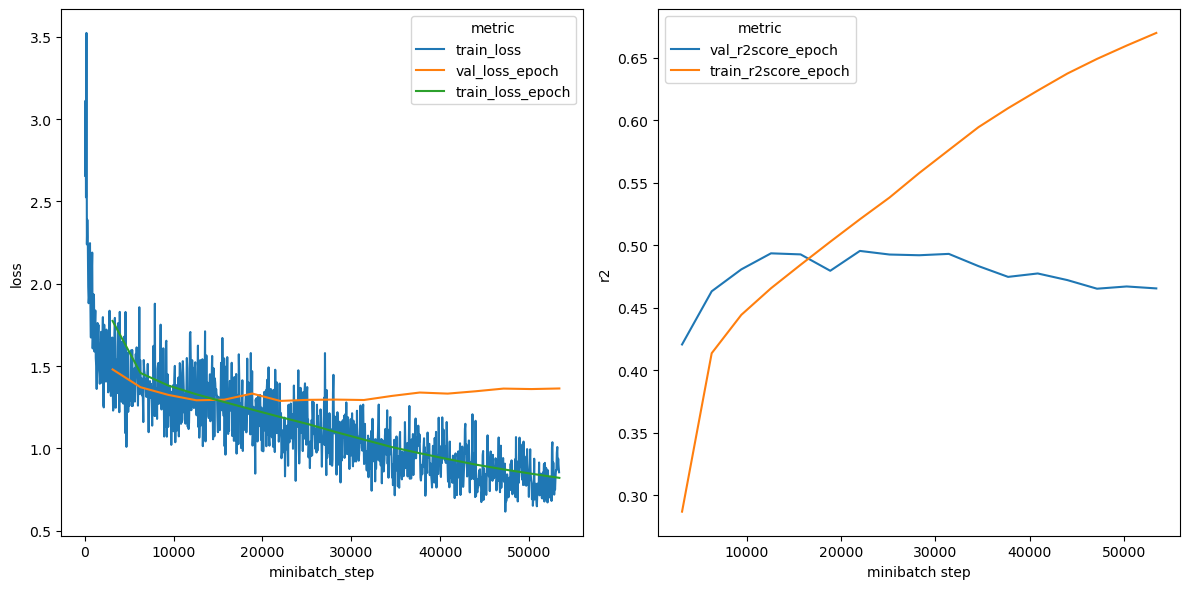

In [52]:
# Plot the training summary
pl.training_summary("/cellar/users/aklie/projects/ML4GLand/issues/41/tutorial_logs/DeepSTARR/Trial1")

# DONE!

---